**Problem 2.1**

**Sleep Latency**

One sleep behavior parameter that we are interested in from the Prober, et al. paper is "sleep latency," which the authors define as "the length of time from lights out to the start of the first rest bout." This could be taken as one measure of sleepiness (or wakefulness); presumably sleepier fish will tend to have lower sleep latency. We will define the start of a rest bout as the first in a string of one or more consecutive "rest minutes" (one-minute bins with no detectable activity for a given fish). 

First, we load the modules we will need for data analysis and plotting.

In [9]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import re

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)


Next, we load the clean, tidy `DataFrame` we created for the one-minute-interval data in tutorial 2a. We will call this `df`. Note that we want the one-minute-interval data because we are looking at rest bouts, which are defined on a minute-by-minute basis. 

In [10]:
# Load the DataFrame from Tutorial 2a.
df = pd.read_csv('./data/130315_1_minute_intervals.csv')

We choose to look at what happens on the third night (the night of "day 2" in the `DataFrame`, since the first day is "day 0"), as the fish should be acclimated to their environment by then.

In [11]:
# Get a view into the third night
df_n2 = df[(df['day']==2) & (df['light']==False)]
df_n2.head()

,fish,genotype,day,light,CLOCK,zeit,activity,window
3146,FISH1,het,2,False,14.011,62.011,6.6,55.7
3147,FISH1,het,2,False,14.028,62.028,8.1,58.0
3148,FISH1,het,2,False,14.044,62.044,6.7,54.5
3149,FISH1,het,2,False,14.061,62.061,3.1,49.2
3150,FISH1,het,2,False,14.078,62.078,1.4,49.3


Next, we define a function, `sleep_latency`. When given an activity series, this function will return the index of the first minute with no detectable activity. As we will apply this function to a `DataFrame` containing only the data from the third night, this index will be equivalent to the number of minutes between turning the light off and the start of the first rest bout. For example, if there is no detectable activity in the first minute after turning off the light, the index will be 0. In other words, this function returns the sleep latency for a given fish. If a fish never has a rest minute during the night, we will say that it has a sleep latency of 600 minutes (the number of minutes in the whole night). We expect that we will subsequently be able to drop these fish as outliers, but we will keep them for now.

In [12]:
def sleep_latency (s, wake_threshold):
    """
    Given activity series s, returns the index of the first minute with
    no detectable activity. 
    """
    # Get Boolean for rest
    rest = (s < wake_threshold)
    
    # Convert to NumPy array if a Pandas Series
    if type(rest) is pd.core.series.Series:
        rest = rest.values
    
    # Find the index of the first minute with no detectable activity
    if True not in rest:
        first_rest = 600
    else:
        first_rest = np.argmax(rest==True)
        
    return first_rest      

Now that we can compute sleep latency, let's look at this parameter for the third night. As in the Prober, et al. paper, we will use a wake threshold of 0. However, because we are using floating point arithmetic, we will set the threshold to be a very small value (as a proxy for 0).  

In [13]:
# Get indices for third night
inds = (~df.light) & (df.day==2)

# Group the DataFrame
df_gb = df[inds].groupby(('fish', 'genotype'))['activity']

## Compute the rest bout lengths
df_sleep_latency = df_gb.apply(sleep_latency, wake_threshold=1e-5).reset_index()
df_sleep_latency = df_sleep_latency.rename(columns={'activity':'latency'})
df_sleep_latency.head()

,fish,genotype,latency
0,FISH1,het,6
1,FISH10,het,8
2,FISH11,mut,14
3,FISH12,mut,15
4,FISH13,mut,14


Okay, this looks good except that our fish are out of order. Although this won't matter for the sake of plotting our data, we'd like to rename the fish so that FISH1 becomes FISH01, FISH2 becomes FISH02, etc., so that when we sort the `DataFrame` by ascending values, all of the fish will be in order.  

In [14]:
# Use a regular expression to search for numbers in the 'fish' column of the DataFrame
regex = re.compile('\d+')
fishnames = np.array(df_sleep_latency['fish'])
nums = [regex.search(i).group() for i in df_sleep_latency['fish']]

# Add a 0 in front of every single-digit number, and rename the fish accordingly
newnums = [str(i).zfill(2) for i in nums]
newnames = ['FISH' + str(i) for i in newnums]
df_sleep_latency['fish'] = pd.Series(newnames)

# Sort the DataFrame by 'fish' in ascending order
df_sleep_latency = df_sleep_latency.sort(columns='fish').reset_index()
df_sleep_latency = df_sleep_latency.drop('index', 1)
df_sleep_latency.head()

,fish,genotype,latency
0,FISH01,het,6
1,FISH02,wt,6
2,FISH03,het,5
3,FISH04,mut,6
4,FISH05,het,8


Now we want to look at our data graphically and make comparisons between the three genotypes. We chose to use box plots, because if there are any fish that did not have a rest bout during the night, their sleep latency (which we artificially set to 600, the total number of minutes in the night) would skew any calculations involving the mean. The median and quartiles are more robust (i.e. better at coping with outliers), and therefore more appropriate in this case. In addition to the box plots, we displayed all the data points by overlaying strip plots, since the total number of data points per genotype is not excessively large. 

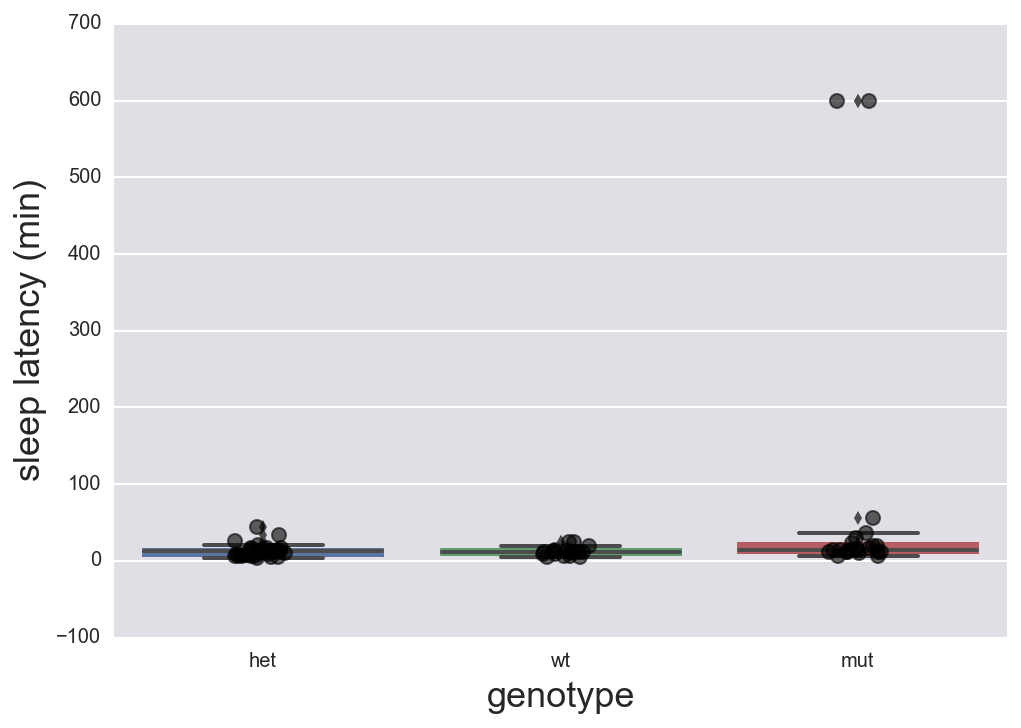

In [16]:
ax = sns.boxplot(x=df_sleep_latency['genotype'], y=df_sleep_latency['latency'])
ax  = sns.stripplot(x=df_sleep_latency['genotype'], 
                    y=df_sleep_latency['latency'], 
                    data=df_sleep_latency, 
                    jitter=True, 
                    alpha=0.6,
                    color='black')
plt.ylabel('sleep latency (min)')

We can see that there were two fish in the mutant genotype that never had a rest bout during the third night (the fish with sleep latency = 600). These fish set the scale for the y-axis, making it difficult to see what's going on with the rest of the data. Let's drop these two outliers and re-do the plot. 

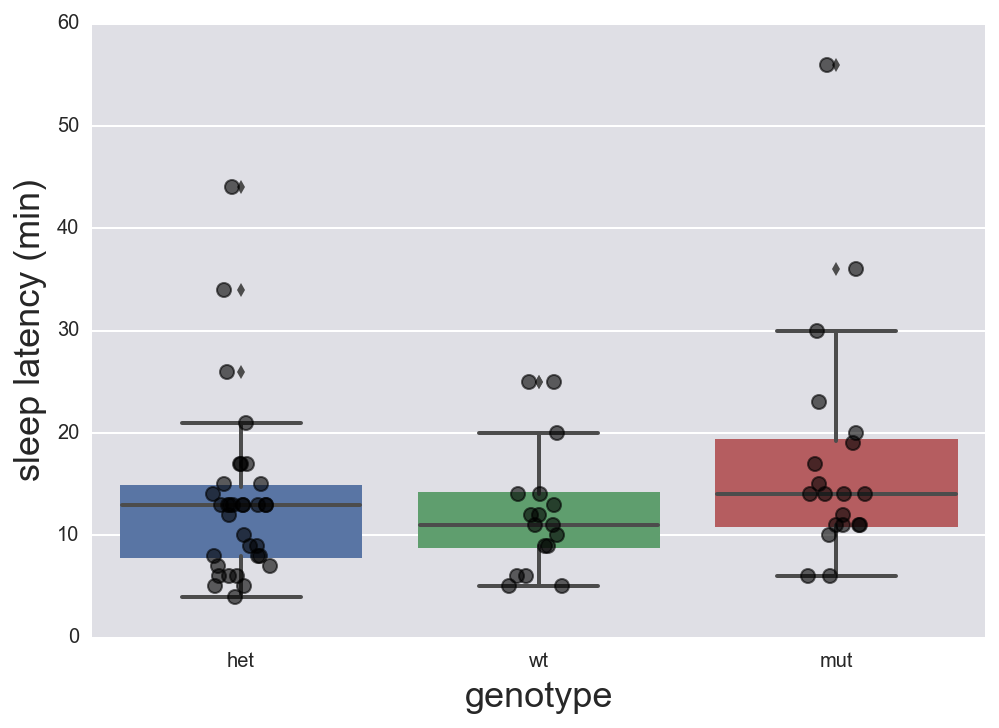

In [17]:
df_drop_outliers = df_sleep_latency[df_sleep_latency['latency'] != 600]
ax = sns.boxplot(x=df_drop_outliers['genotype'], y=df_drop_outliers['latency'])
ax  = sns.stripplot(x=df_drop_outliers['genotype'], 
                    y=df_drop_outliers['latency'], 
                    data=df_drop_outliers, 
                    jitter=True, 
                    alpha=0.6,
                    color='black')
plt.ylabel('sleep latency (min)')

Much better. 

Since we were asked to estimate the values of the parameters we are interested in, we will also directly calculate the median for each genotype. Looking at the box plots above, we can see that even in the case of the mutant, where two outliers did not rest at all, there were three fish right at the median. Therefore, we will get the same median regardless of whether we drop the two fish that didn't rest. 

In [ ]:
# Calculate the median sleep latency for each genotype and return it as a new DataFrame
median_latency = df_sleep_latency.groupby('genotype')['latency'].median().reset_index()
median_latency = median_latency.rename(columns={'latency':'median sleep latency (min)'})
median_latency

Although the median sleep latency (and overall spread) for the mutant are slightly greater than for the wildtype or heterozygous, the difference is not large enough for us to feel confident in giving a firm conclusion that the mutant tends to have a longer sleep latency. 

<u>Strengths and weaknesses of sleep latency as a parameter</u>

The primary strength of sleep latency as a parameter of sleep behavior is that it is a self-explanatory metric for the ability of a fish to initiate sleep at night. Deficiency in this ability is one of the criteria for insomnia (Prober et al., 2006). Sleep latency specifically measures this ability (which could plausibly be regulated differently than other aspects of sleep), unlike other metrics such as average activity throughout the night, or length or number of rest bouts. Average length of time between rest bouts could be taken as a similar measure of ability to initiate sleep, but we favor our sleep latency metric for its simplicity. 

However, sleep latency also has some weaknesses as a parameter of sleep behavior. <b>1)</b> The most obvious weakness is in the case that a fish never has a rest bout during the night. Although we chose to artificially set the maximum sleep latency as the total number of minutes in the night, we do not think this is really a satisfactory representation of never having a rest bout. Yet we could not think of a better way to quantitatively represent fish that do not have a rest bout, since we simply do not have enough information about these fish: all we can know is that their true sleep latency was somewhere between 600 minutes and infinity. Artificially setting the maximum also prevents us from using the mean as a metric, although arguably the mean would not be appropriate anyway since there are other outliers besides the fish that do not sleep at all (as shown in the box plots above). <b>2)</b> We are not familiar with to how to calculate a posterior distribution for the median, although this is a limitation of our statistical knowledge rather than a limitation of the metric itself. <b>3)</b> Sleep latency is a measure of a very specific aspect of sleep behavior, rather than general sleepiness/wakefulness. For this reason, we think that while it could be a valuable metric, it would be best to combine it with metrics for several other aspects of sleep behavior. 